# Quantum Phase Estimation (QPE) for Solving Molecular Energies


Quantum Phase Estimation (QPE) is a key algorithm in quantum computing, allowing one to estimate the phase (or eigenvalue) of an eigenvector of a unitary operation. For a given Hamiltonian $H$, and an eigenvalue ${|\psi\rangle}$, the output of the algorithm is $\epsilon$ where

$U{|\psi\rangle} = e^{2\pi i\epsilon}{|\psi\rangle} , U = e^{2\pi iH}$ .


Therefore, by measuring the phase accumulated, the QPE algorithm allows calculating the energies relating to the chosen initial state.
When using QPE for chemistry problems, it is common to search for the lowest energy of a given molecule. As the molecule can be written in the form of a Hamiltonian (Hermitian matrix representing the energetic forces of the structure), one only needs to insert the ground eigenvector in order to obtain the minimal energy value using QPE. However, obtaining the ground state is not a trivial problem. In order to overcome it, it is sufficient to use a state with big overlap with the ground state.

We define a state ${|v\rangle}$ which will be chosen as the algorithm's initial state. Let us define {$\psi_i$} to be the set of (unknown) eigenvalues of $H$. Generally, any vector can be rewritten as a superposition of any basis set, thus -

${|v\rangle} = \sum_i a_i{|\psi_i\rangle}$

and -

$U{|v\rangle} = \sum_i a_i e^{2\pi i\epsilon_i}{|\psi_i\rangle}$.

where ${\epsilon_i}$ are the eigenvalues of $H$, i.e. the span of energies relating to the molecule. Using execution with enough shots, one will obtain this set of $\epsilon_i$, i.e., a subset of the Hamiltonian's eigenvalues. As we are specifically interested in $\epsilon_0$, the ground state of $H$, it is important that there is a large overlap between ${\psi_0}$ and ${|v\rangle}$ so the probability to measure ${\epsilon_0}$ is high, i.e.

$P(\epsilon_0) = |\langle v|\psi_0\rangle|^2 > \zeta $.

How large is $\zeta$? After execution, we will obtain a set of ${E_i}$. If we have done 1000 shots of execution, and $P(\epsilon_0)>1\%$, we should sample $\epsilon_0$ about 10 times.

A common choice for ${|v\rangle}$ (the initial state) is the Hartree-Fock (HF) state, which typically has a large overlap with the ground state. However, other guesses for the initial state are possibly good or even better fit, and choosing the right initial state is a sort of art and an active field of research.

For further reading about QPE we recommend [[1](#NC)].


**What are the benefits of using QPE algorithm for finding a molecule's ground state?**

The two most prominent methods to solve ground energy for molecules are quantum variational algorithm (VQE) and QPE. Those promise better scalability compared to classical counterparts as the molecules becomes more complex, with larger number of electrons, referring to a physical problem with more degrees of freedom.

The number of parameters in VQE is closely related to the number of electrons. This may create inherent difficulty achieving high-precision calculations through sampling statistical estimators, and perhaps even not converge for very large systems. On the other hand, the number of parameters in QPE is a flexible value which is directly related to the resolution of the problem, but is not bounded with the number of electrons.

Furthermore, it is known that advanced quantum algorithms based on QPE can perform electronic structure calculations in sub-exponential time with accuracy that rivals exact diagonalization methods. This guarantee of simultaneously achieving high accuracy, efficiency, and generality is a feat that is believed to be impossible for classical algorithms. For those reasons, VQE is applicable in the near term (NISQ) era, while QPE is suited for fault-tolerant design.

**In this tutorial, we follow the QPE algorithm steps as follows:**

1. Define a molecule and convert it into a Hamiltonian.

2. Prepare the Hamiltonian for QPE: including normalization and trimming of negligible terms.

3. Construct a quantum model: initializing the state for the HF state and leveraging the `qpe_flexible` function.

4. Executing the circuit to find the related phases and analyzing the results to find the ground state.

In [1]:
## Imports

import matplotlib.pyplot as plt
import numpy as np

from classiq import *
from classiq.applications.chemistry.op_utils import qubit_op_to_pauli_terms

# for chemistry
from classiq.applications.chemistry.problems import FermionHamiltonianProblem
from classiq.applications.chemistry.z2_symmetries import Z2SymTaperMapper

## Defining a molecule with Classiq

In this tutorial we choose to work on the LiH molecule:

In [2]:
molecule_H2_geometry = [("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, 0.735))]
molecule_O2_geometry = [("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, 1.16))]
molecule_LiH_geometry = [("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, 1.596))]
molecule_H2O_geometry = [
    ("O", (0.0, 0.0, 0.0)),
    ("H", (0, 0.586, 0.757)),
    ("H", (0, 0.586, -0.757)),
]
molecule_BeH2_geometry = [
    ("Be", (0.0, 0.0, 0.0)),
    ("H", (0, 0, 1.334)),
    ("H", (0, 0, -1.334)),
]

molecule_geometry = molecule_LiH_geometry

In [3]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

geometry = molecule_H2_geometry

basis = "sto-3g"  # Basis set
multiplicity = 1  # Singlet state S=0
charge = 0  # Neutral molecule
molecule = MolecularData(molecule_geometry, basis, multiplicity, charge)

molecule = run_pyscf(
    molecule,
    run_mp2=True,
    run_cisd=True,
    run_ccsd=True,
    run_fci=True,  # relevant for small, classically solvable problems
)

In [4]:
# define your molecule problem and mapper

problem = FermionHamiltonianProblem.from_molecule(
    molecule=molecule, first_active_index=1
)
mapper = Z2SymTaperMapper.from_problem(problem)
num_qubits = mapper.get_num_qubits(problem)

constant_energy = problem.fermion_hamiltonian.constant
mol_hamiltonian = mapper.map(problem.fermion_hamiltonian - constant_energy)

print(
    f"The Hamiltonian is defined on {num_qubits} qubits, and contains {len(mol_hamiltonian.terms)} Pauli strings"
)

The Hamiltonian is defined on 6 qubits, and contains 231 Pauli strings


Finally, we calculate the ground state energy as a reference solution to our quantum solver

In [5]:
classical_sol = molecule.fci_energy
print(f"Expected energy: {classical_sol} Ha")

Expected energy: -7.882386993638953 Ha


## Preparing the Molecule for QPE

### Trimming the Hamiltonian

As we can see, the Hamiltonian may contain a large number of terms. In many cases we can compress the Hamiltonian by trimming small terms.

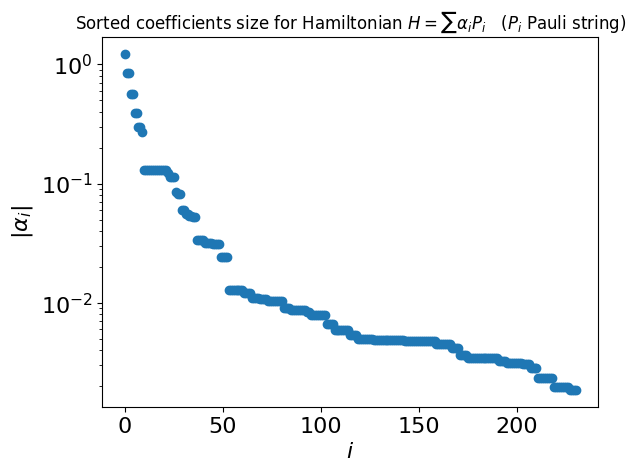

In [6]:
coeffs = list(mol_hamiltonian.terms.values())
plt.semilogy(np.sort(np.abs(coeffs))[::-1], "o")
plt.ylabel(r"$|\alpha_i|$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title(
    r"Sorted coefficients size for Hamiltonian $H = \sum \alpha_i P_i$   ($P_i$ Pauli string)"
);

We define some threshold and trim the Hamiltonian accordingly:

In [7]:
THRESHOLD = 0.03

mol_hamiltonian.compress(THRESHOLD)
print(f"Length of trimmed Hamiltonian: {len(mol_hamiltonian.terms)}")

Length of trimmed Hamiltonian: 49


### Normalizing the Hamiltonian for QPE

Since we are working with QPE, the ground state energy is inferred as a phase, thus, we shall normalize the Hamiltonian such that its eigenvalues are in $\left[-\frac{1}{2},\frac{1}{2}\right)$. This is done by finding a bound on the maximal absolute value of eigenvalues $\tilde{\lambda}_{\max}$, and normalizing the Hamiltonian by $2\tilde{\lambda}_{\max}$. A simple bound is given by the sum of Pauli coefficients of the Hamiltonian.

In [8]:
def normalize_hamiltonian(hamiltonian):
    approx_lambda_max = sum(np.abs(value) for value in hamiltonian.terms.values())
    normalization = 2 * approx_lambda_max

    normalized_mol_hamiltonian = hamiltonian * (1 / normalization)
    return normalization, normalized_mol_hamiltonian


normalization, normalized_mol_hamiltonian = normalize_hamiltonian(mol_hamiltonian)
print(f"The normalization value of the Hamiltonian is {normalization}")

The normalization value of the Hamiltonian is 17.61546220154498


## Designing the Quantum Model

### Defining a powered Hamiltonian simulation

We will now create a quantum model of the QPE algorithm using the Classiq platform. In particular, we will use the open library  [qpe_flexible](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qpe/qpe.ipynb) function (see [notebook](https://github.com/Classiq/classiq-library/blob/main/tutorials/advanced_tutorials/high_level_modeling_flexible_qpe/high_level_modeling_flexible_qpe.ipynb) as well).

We need to approximate the Hamiltonian simulation $e^{2\pi i H}$, for this we will use Classiq built-in implementation for [Suzuki Trotter formulas](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/qmod_core_library/hamiltonian_evolution/suzuki_trotter/suzuki_trotter.ipynb). For a given Suzuki Trotter order $o$, we can specify a repetitions parameter $r$, which controls the level of approximation. The literature provides some lower bounds for $r$ as a function of the operator error $\epsilon$ (defined by the dimond norm [[3](#Dimond)]). For example, Eq. (14) in Ref. [[2](#Bounds)]  states that Suzuki Trotter formula of order 2 approximates $e^{i \sum \alpha_m P_m t}$ up to an error $\epsilon$, given $r$ repetitions that satisfies:
$$
r \leq \left(\frac{2^5\gamma_2}{3\epsilon}\right)^{1/2}  t^{3/2} ,
\tag{1}
$$
where $\gamma_2 \equiv \sum_{l,m,n} |\alpha_m\alpha_n\alpha_l| \left |\left[P_l,\left[P_m, P_n\right]\right]\right|_\infty$. **In particular, we can see that the number of repetitions grows as $t^{3/2}$**.


In QPE, we apply powered Hamiltonian simulation:
$$
\left(e^{2\pi i H}\right)^ p = e^{2p \pi i H},
\tag{2}
$$
and each power should be approximated with Suzuki Trotter with an appropriate order and repetitions parameters, keeping the same error per QPE iteration. We can thus use the bound above to define a powered Suzuki Trotter `qfunc` for our specific molecule.

First, we first define a classical auxiliary functions that helps us to evaluate the right-hand-side in Eq. (1):

In [9]:
import itertools

from openfermion import QubitOperator
from openfermion.utils import commutator


def calculate_gamma_2(hamiltonian):
    """
    Compute the $\gamma_2$ value appearing in the bound for Suzuki Trotter of order 2
    """
    gamma_2 = 0
    for triplet in itertools.combinations(range(len(hamiltonian.terms)), 3):
        terms = [list(hamiltonian.terms.keys())[index] for index in triplet]
        values = [list(hamiltonian.terms.values())[index] for index in triplet]
        factor = np.abs(values[0] * values[1] * values[2])
        inner_commutator = commutator(
            QubitOperator(terms[1], 1), QubitOperator(terms[0], 1)
        ).induced_norm()
        if inner_commutator != 0:
            outer_commutator = (
                2
                * commutator(
                    QubitOperator(terms[2], 1),
                    QubitOperator(terms[0], 1) * QubitOperator(terms[1], 1),
                ).induced_norm()
            )
            gamma_2 += factor * outer_commutator

    return gamma_2

In QPE, the powers of the Hamiltonian simulation grows exponentially with the phase variable size. Let us examine the number of repetitions needed per QPE iteration, according to the bound above for QPE of size 7.

In [10]:
QPE_SIZE = 7
qpe_powers = 2 ** np.arange(QPE_SIZE)
print(
    f"""The powers of the Hamiltonian simulation along a QPE routine of size {QPE_SIZE}: 
{qpe_powers}"""
)

The powers of the Hamiltonian simulation along a QPE routine of size 7: 
[ 1  2  4  8 16 32 64]


These powers enter as an evolution coefficient for the Hamiltonian simulation (see Eq. (2) above). Using the theoretical bound we find

In [11]:
EPS = 0.1
gamma_2_LiH = calculate_gamma_2(normalized_mol_hamiltonian)
theoretical_r0 = np.sqrt(2**5 * gamma_2_LiH / (3 * EPS)) * (2 * np.pi) ** (3 / 2)

print(
    f"""The theoretical bounds for the repetitions for QPE size {QPE_SIZE}, keeping an error {EPS} per QPE iteration are:
{np.ceil(theoretical_r0*qpe_powers**(3/2))}"""
)

The theoretical bounds for the repetitions for QPE size 7, keeping an error 0.1 per QPE iteration are:
[   5.   12.   33.   93.  261.  737. 2084.]


We note that applying a naive QPE, i.e., assuming a single unitary approximated with Suzuki Trotter, $e^{iHt} \approx {\rm ST}(H, o, r ,t)$, and simply taking its powers, gives $\left(e^{iHt}\right)^p \approx \left({\rm ST}(H, o, r ,t)\right)^{p} = {\rm ST}(H, o, pr ,pt)$.

In [12]:
print(
    f"""The repetitions for QPE size {QPE_SIZE}, taking a naive QPE, per QPE iteration:
{np.ceil(theoretical_r0*qpe_powers)}"""
)

The repetitions for QPE size 7, taking a naive QPE, per QPE iteration:
[  5.   9.  17.  33.  66. 131. 261.]


While this naive QPE results in a shallower circuit, compared to taking repetitions according to the theoretical bounds (due to smaller values of repetitions), it is unclear whether it keeps the same operator error per phase bit.

In practice, the bounds given in the literature are quite loose. In this tutorial we thus take a more experimental approach. We assume that the scaling of the bound with the evolution time $t$ is similar to Eq. (1), but take a smaller prefactor. 

In [13]:
experimental_r0 = 0.05
print(
    f"""The experimental repetitions for QPE size {QPE_SIZE}, per QPE iteration are:
{np.ceil(experimental_r0*qpe_powers**(3/2))}"""
)

The experimental repetitions for QPE size 7, per QPE iteration are:
[ 1.  1.  1.  2.  4. 10. 26.]


Now, we use this approach to define our powered Suzuki Trotter function, for the specific Hamiltonian at hand.

In [14]:
from classiq.qmod.symbolic import ceiling as ceiling_qmod, pi


@qfunc
def powered_st2_for_LiH(p: CInt, state: QArray[QBit]):
    multi_suzuki_trotter(
        hamiltonians=[qubit_op_to_pauli_terms(normalized_mol_hamiltonian)],
        evolution_coefficients=[-2 * np.pi * p],
        order=2,
        repetitions=ceiling_qmod(experimental_r0 * p ** (3 / 2)),
        qbv=state,
    )

### Defining and synthesizing the phase estimation model

In [15]:
from classiq.applications.chemistry.hartree_fock import get_hf_state

hf_state = get_hf_state(problem, mapper)


@qfunc
def main(
    state: Output[QArray[QBit, num_qubits]],
    phase: Output[QNum[QPE_SIZE, SIGNED, QPE_SIZE]],
) -> None:

    prepare_basis_state(hf_state, state)
    allocate(phase)
    qpe_flexible(lambda p: powered_st2_for_LiH(p, state), phase)


qmod = create_model(
    main,
    preferences=Preferences(timeout_seconds=600),
)
write_qmod(qmod, "qpe_for_molecules", symbolic_only=False)

qprog = synthesize(qmod)

## Measurment and Analysis


First we execute on the default simulator:

In [16]:
res = execute(qprog).result_value()

Next, we draw a histogram for the energies, by taking the output of the `phase` variable and multypling back the normalization facor and the constant energy.


Energy with maximal probability: -7.904148198365434 Ha
Precision: 0.13762079844957015 Ha
Classical solution:, -7.882386993638953 Ha


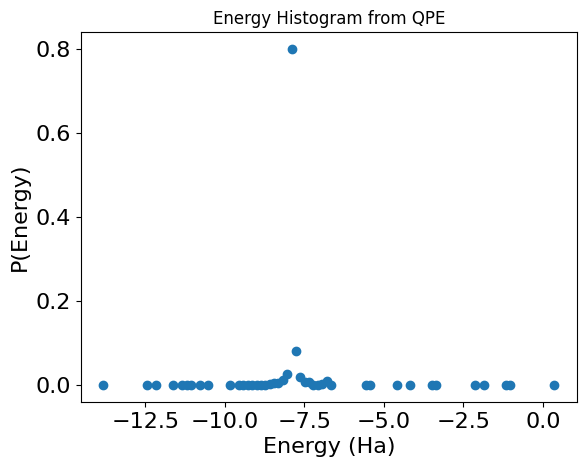

In [17]:
phase_counts = res.parsed_counts_of_outputs("phase")
num_shots = res.num_shots

energy_results = {
    sample.state["phase"] * normalization + constant_energy: sample.shots / num_shots
    for sample in phase_counts
}

plt.plot(energy_results.keys(), energy_results.values(), "o")

max_prob_energy = max(energy_results, key=energy_results.get)

print(f"\nEnergy with maximal probability: {max_prob_energy} Ha")
print(f"Precision: {(2**(-QPE_SIZE))* normalization} Ha")
print(f"Classical solution:, {classical_sol} Ha")
plt.xlabel("Energy (Ha)", fontsize=16)
plt.ylabel("P(Energy)", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title("Energy Histogram from QPE");

Recall that we are looking for a signal from the smallest eigenvalue, under the assumption that the initial state has some overlap with the ground state. Below we estimate the energy as the first peak of the histogram, such that the corresponding probability is larger than `ASSUMED_OVERLAP`*0.4 (0.4 is the case for ASSUMED_OVERLAP=1).

*Note that this is a very rough and simplistic analysis of the QPE algorithm result. One can utilize more complex tools of spectral analysis, such as Gaussian mixtures, etc. Additional assumptions, such as difference between adjacent eigenvalues or number of overlapping eigenstates, can facilitate the analysis further.*

In [18]:
from scipy.signal import find_peaks

ASSUMED_OVERLAP = 0.05


def estimate_energy(data_dict, assumed_overlap):
    max_prob = assumed_overlap * 0.4
    data = tuple(data_dict.items())
    data_sorted = sorted(
        data, key=lambda x: x[0]
    )  # sort the data according to the energy value
    probs_sorted = [data[1] for data in data_sorted]
    maxima = find_peaks(probs_sorted, height=max_prob)[0]
    print(f"Number of maxima: {maxima.size}")
    if maxima.size == 0 and np.all(np.array(probs_sorted) <= max_prob):
        print(
            """No probabilities above threshold were found, try to increase the assumed_overlap. 
Returning energy with max probability"""
        )
        return max(data_dict, key=data_dict.get)
    elif maxima.size == 0:  # strictly increasing or decreasing function
        return max(data_dict, key=data_dict.get)
    else:
        print(
            f"maxima over the threshold at {[data_sorted[maxima[k]][0] for k in range(maxima.size)]} Ha"
        )
        return data_sorted[maxima[0]][0]


measured_energy = estimate_energy(energy_results, ASSUMED_OVERLAP)
print(f"\nLowest eigenvalue: {measured_energy} Ha")
print(f"Precision: {(2**(-QPE_SIZE))* normalization} Ha")
print(f"Classical solution:, {classical_sol} Ha")

Number of maxima: 1
maxima over the threshold at [-7.904148198365434] Ha

Lowest eigenvalue: -7.904148198365434 Ha
Precision: 0.13762079844957015 Ha
Classical solution:, -7.882386993638953 Ha


## References

<a name='NC'>[1]</a>: [Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition, Cambridge University Press, New York, NY, USA.
](https://archive.org/details/QuantumComputationAndQuantumInformation10thAnniversaryEdition)

<a name='Bounds'>[2]</a>: [M. Hagan and N. Wiebe. Composite Quantum Simulations, Quantum 7, 1881 (2023).
](https://quantum-journal.org/papers/q-2023-11-14-1181/)

<a name='Diamond'>[3]</a>: [Diamond Norm (Wikipedia)
](https://en.wikipedia.org/wiki/Diamond_norm)

